In [2]:
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [3]:
seasons = [2014, 2015, 2016, 2017, 2018]
weeks = range(1, 17)
pos = {
    "D/ST": 99,
    "RB": 20,
    "WR": 30,
    "QB": 10
}
sample_url = 'https://www.fftoday.com/stats/playerstats.php?Season=2018&GameWeek=1&PosID=99&LeagueID=143908'

url_build = "https://www.fftoday.com/stats/playerstats.php?Season={season}&GameWeek={week}&PosID={pos}&LeagueID=143908"


def positionDataScrape(pos):
    data = []
    for season in seasons:
         for week in weeks:
            data += scrapePosBySeasonWeek(pos, season, week)
    #sys.stdout.flush()
    return data

def scrapePosBySeasonWeek(pos, season, week):
    data = []
    url = url_build.format(season=season, week=week, pos=pos)
    #sys.stdout.write("\rScrapping {}\t\t".format(url))

    stat_page = urlopen(url)
    stat_soup = BeautifulSoup(stat_page, 'html.parser')
    header = stat_soup.find('tr', class_='tableclmhdr')
    group_header = stat_soup.find('tr', class_='tablehdr')
    rows = header.find_next_siblings('tr')

    group_headers = []
    next_header_index = 0
    for td in group_header.find_all('td')[:-1]: # All group headers minus the last one which is always "Fantasy"
        num_headers = int(td['colspan'])
        group = { 'name': td.get_text().strip(), 'num_headers': num_headers, 'offset': next_header_index }
        group_headers.append(group)
        next_header_index += num_headers

    keys = []
    for td in header.find_all('td'):
        keys.append(td.get_text().strip())

    for group in group_headers:
        if group["name"] == '':
            continue
        span = slice(group['offset'], group['offset'] + group['num_headers'])
        keys[span] = ["{} - {}".format(group['name'], k) for k in keys[span]]


    keys.append('Season')
    keys.append('Week')


    for tr in rows:
        game = {k:None for k in keys}
        i = 0
        for td in tr.find_all('td'):
            game[keys[i]] = td.get_text().strip()
            i += 1
        game['Season'] = season
        game['Week'] = week
        game[keys[0]] = re.sub('^[\W\d]+', '', game[keys[0]])
        game[keys[0]] = re.sub('[\n\r\t]+', '', game[keys[0]])
        game[keys[0]] = re.sub('(s|S)ort\s', '', game[keys[0]]) # Remove the word "sort"
        data.append(game)
        
    return data

def customDefScoring(game):
    score = 0.0
    score += standardDefPts(game)
    if game['PA'] == 0:
        score += 28
    elif game['PA'] <= 6:
        score += 21
    elif game['PA'] <= 13:
        score += 14
    elif game['PA'] <= 20:
        score += 7
    elif game['PA'] <= 27:
        score += 0
    elif game['PA'] <= 34:
        score += -7
    elif game['PA'] >= 35:
        score += -14

    return score

def customDefScoring4(game):
    score = 0.0
    score += standardDefPts(game)
    if game['PA'] == 0:
        score += 20
    elif game['PA'] <= 6:
        score += 15
    elif game['PA'] <= 13:
        score += 10
    elif game['PA'] <= 20:
        score += 5
    elif game['PA'] <= 27:
        score += 0
    elif game['PA'] <= 34:
        score += -5
    elif game['PA'] >= 35:
        score += -10

    return score

def standardDefPts(game):
    return (1 * game['Sack']) + (2 * game['INT']) + (6 * game['DefTD']) + (6 * game['KickTD']) + (2 * game['Safety'])

In [4]:
data = positionDataScrape(pos["D/ST"])

In [5]:
df = pd.DataFrame(data)
df = df.astype({k:'float64' for k in df.columns[1:-2]})

In [6]:
df['CustFPts'] = df.apply(customDefScoring, axis=1)
df['ProposedCustFPts'] = df.apply(customDefScoring4, axis=1)

In [7]:
wr_data = positionDataScrape(pos['WR'])

In [8]:
wr_df = pd.DataFrame(wr_data)
wr_df = wr_df.astype({k:'float64' for k in wr_df.columns[2:-2]})

In [9]:
rb_data = positionDataScrape(pos['RB'])
rb_df = pd.DataFrame(rb_data)
rb_df = rb_df.astype({k:'float64' for k in rb_df.columns[2:-2]})

In [10]:
qb_data = positionDataScrape(pos['QB'])
qb_df = pd.DataFrame(qb_data)
qb_df = qb_df.astype({k:'float64' for k in qb_df.columns[2:-2]})

In [11]:
qb_df['CustFPts'] = qb_df.apply(lambda game: game['FPts'] + (game['Passing - TD'] * 2) + (game['Passing - Yard'] * -0.01), axis=1)

# Playing for Keeps - Defense Scoring System

## TL;DR

We made a D/ST scoring system originally that was designed to

1. make the Defense more of a QB-like player on a GM's roster
2. make low PA more valuable than the random D/ST TD

Generally, all the analysis in the last 2 days has told us, yeah, the scoring system is doing that, but maybe a _little_ too much.

To help alleviate the league's apprehension and hopefully help make the meta of the position easier to manage (and less harmful if mis-managed), we're proposing a D/ST scoring change that changes the PA **going forward** to:

- 0 PA : 20
- 1-6 PA: 15
- 7-13 PA: 10
- 14-20 PA: 5
- 21-26 PA: 0
- 27-34 PA: -5
- 35+ PA: -10

This will not _devalue_ big games like what the Patriots did on Sunday, but this _will_ make the max score less overall (Patriots would have gotten 47 instead of 55). Lastly, it _will_ make defenses movement in points _less_, and high scoring games 21+ points, will be about as common as a WR getting a 21+ game.

You can look at the [stats section](#stats-appendix) for all the info we have on the current D/ST scoring and the proposed one (including team by team stats on each system by season).

## Last Sunday

The Patriot's Defensive performace last Sunday against Miami (week 2 of the 2019 season) was _the best_ defensive performance in terms of Fantansy points since the Titans defense and special teams destroyed Jacksonville in 2012 week 17. The Titans and Patriots each scored 37 fantansy points (using standard scoring).

However, the Patriots had a huge "one-up" on the Titans performance. Miami never scored. Titans had two special teams touchdowns that catipulted them to there 37 fantasy points (and 2 defense touchdowns off of 3 interceptions), however, Jacksonville still put 20 point on the board against the Titans defense.

## Why the hell does D/ST matter anyway

Well, some might say for Fantasy Football it _shouldn't_ matter. It's not typically considered a "skill" player position.

My 2¢ on that:

**bull shit**

Defense is half of football, and I like leagues where it gets treated (more) like it. I also recognize though, that unless you in an IDP league, a GM doesn't really get control over individual aspects of the defense or special teams. You're stuck with a whole team's ensemble. This makes it less deterministic, more volitile, and consequently harder to gauge a good defense and get a consistent score from them.

### We tried to make D/ST matter more

For our league, we tried to make D/ST matter more without the GMs having to deal with the time sink that is IDP. Our goal was to treat defenses more like a QB position in point and spread. Afterall, there's only one QB and only one D/ST starter. We thought this seemed reasonable pre-draft, and when we ran numbers (against season average and stats for the last 5 seasons), it also looked valid. You only had about 12% chance of a defense scoring 21+ fantasy points, and the average defensive fantasy points was right at 7 fantasy points. That was pretty much right up there with QBs who had 14 average fantasy points and a 28% chance of having a 21+ fantasy point performance.

We also added higher penalties for high PA. This helped mitigate, we thought, performances like the Titans. In standard scoring they were at 37 fantasy points, but with 20PA that game, our custom scoring only gave them 20pts. Still a good showing, but it helped balance the scales and valued the primary defense goal of stopping the opposing offense more than more random "offense-like" scoring by the defense.

Text(0, 0.5, '# of player games')

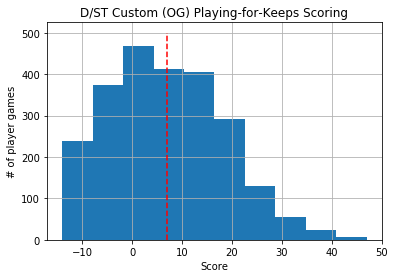

In [12]:
df.CustFPts.hist()
plt.title("D/ST Custom (OG) Playing-for-Keeps Scoring")
plt.vlines(df.CustFPts.mean(), 0, 500, ['r'], 'dashed', 'avg')
plt.xlabel("Score")
plt.ylabel("# of player games")

Text(0, 0.5, '# of player games')

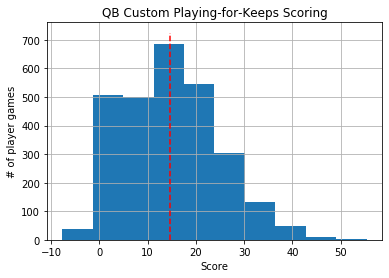

In [13]:
qb_df.CustFPts.hist()
plt.title("QB Custom Playing-for-Keeps Scoring")
plt.vlines(qb_df.CustFPts.mean(), 0, 725, ['r'], 'dashed', 'avg')
plt.xlabel("Score")
plt.ylabel("# of player games")

### Our assumption: strong defenses showings rarely include D/ST TDs

Our primary (perhaps naïve) assumption was that
> It's statistically _very unlikely_ for a defense to both have a shutout in PA **and** have high play-based scores.

In our analysis of the last 5 seasons (before the draft), of all the shutouts (on average about 5-6 a season), the average score was 36 fantasy points and the max ever seen was 47. We knew this was quite different from standard scoring because standard scoring values things like defensive touchdowns _way_ more (relatively) than to keeping your opponent from geting touchdowns. 

You can see below, while we knew some high scores _could_ happen, they rarely happened. Only 1.4 games out of an entire _season_ would see a defense having a score of 40+ fantasy points. Compared to QBs that have 6.5 games a season at 40+ fantasy points.

In [14]:
df.where(df.PA == 0)[['FPts', 'CustFPts']].describe(percentiles=[0.25,0.50,0.75,0.90])

,FPts,CustFPts
count,28.000000,28.000000
mean,10.107143,36.607143
std,4.954155,4.507930
min,3.000000,31.000000
25%,6.750000,33.000000
50%,8.000000,35.500000
75%,13.250000,39.250000
90%,17.000000,42.200000
max,22.000000,47.000000


As we know now that week 2 and the Patriots absolute domination of Miami has come and gone, that assumption was proven to be wrong.

However, is this "the exception that proves the rule" or is it the game that proves that, inherently, the scoring allows big showings to just be bigger?

We've struggled with that for a few days now while looking through _game-by-game_ stats and crunching numbers.

### Volitility in D/ST fantasy points

So far, I would say the existing scoring system is "working as intended" by acting more like a QB (with just less likelihood of high scoring games) **except** in one point.

In stats, this is called "standard deviation". Typically, standard deviation is a good indicator of "volitility". If the standard deviation is way higher than the average (aka the "mean"), then the average is very "uncertain".

In our original scoring system evaluation, that's one stat we didn't look at (because we didn't have game-by-game data to compare against). Unfortunately, the system had defenses scoring an average of 7.0 fantasy points, but the standard deviation was *11.5* fantasy points. That's a ratio of 1.6 times the average! 

That means, as a GM D/ST is a big risk-reward player. It could really hurt you on a bad week, but _really_ help you on a good week. It's easier if we visualize it:

Text(0, 0.5, '# of player games')

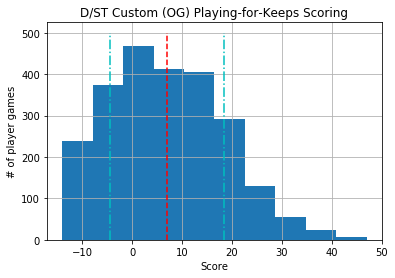

In [15]:
df_avg = df.CustFPts.mean()
df_std = df.CustFPts.std()
df.CustFPts.hist()
plt.title("D/ST Custom (OG) Playing-for-Keeps Scoring")
plt.vlines([df_avg, df_avg + df_std, df_avg - df_std], 0, 500, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")

The red line in the middle is the average, the cyan lines on either side are "1 standard deviation" away from the average. The wider the space between the blue bars, the more **dramatic** the volitility. However, all the dark blue inside that "1 standard deviation" range tells us how many games were in that range. You can see that there are a _lot_ of games covered inside the two cyan bars.

To be precise, the pecentage of games within 1 standard deviation of games is:

In [16]:
print("{0:.0%}".format(df.where(df.CustFPts >= (df_avg - df_std)).where(df.CustFPts <= (df_avg + df_std)).G.count() / df.G.count()))

64%


The closer to `50%` *and* the *wider* the 1 standard deviation range, the **more** volitile the fantasy score is.

Another way to say all this information is: "There is a 64% chance of my D/ST scoring 6.9 ± 11.4 points".

That means, as a GM, D/ST is a big risk-reward player. It could really hurt you on a bad week, but _really_ help you on a good week. That _doesn't_ tell us, though, how _likely_ you are to get a bad week versus a good week.

However, we're used to that same meta with another position, the QB. The QB has a standard deviation of *10.0* fantasy points, but it's a little offset by an average of 14.7 fantasy points (0.68 ratio).

65% of games are within 1 standard deviation


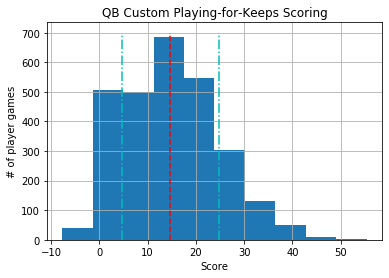

In [17]:
qb_avg = qb_df.CustFPts.mean()
qb_std = qb_df.CustFPts.std()
qb_df.CustFPts.hist()
plt.title("QB Custom Playing-for-Keeps Scoring")
plt.vlines([qb_avg, qb_avg + qb_std, qb_avg - qb_std], 0, 700, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("{0:.0%} of games are within 1 standard deviation".format(qb_df.where(qb_df.CustFPts >= (qb_avg - qb_std)).where(qb_df.CustFPts <= (qb_avg + qb_std)).G.count() / qb_df.G.count()))

In fact, QBs are _very_ similar to the D/ST (just very slightly less volitile). This brings us to the real problem, did everyone _expect_ the D/ST to be a 2nd QB?

### The primary "problem" with the current D/ST scoring system

The reason some of us our feeling the burn from the D/ST is two-fold:

1. Some (if not most) of us didn't expect a "second more-volitile QB" impact from the D/ST
2. The current meta is quite different from standard and while similar to a QB, is harder for GMs to gauge

While we talked about how we thought the D/ST meta would change during the initial setup of the league (and scoring rules were always visible to everyone), no one had a good feel for exactly _what_ value D/ST would have in the league. We couldn't give you game-by-game stats or team wide performances. Only the averages and typical performances for shutouts.

The second issue is part of the volitility that can make D/ST not fun as a GM. The first was entirely **our fault** as commissioners. In truth, while we shared what stats we had at prior to the draft, we didn't hit that home and do any game-by-game analysis. Probably, many of us would have tried to draft defenses a _little_ eariler in the draft process had we seen comparisons to other positions or standard scoring.

There isn't much we can do about the first part of the problem, but if we attempt to tweak the scoring system we _may_ help alleviate the second part and make the meta easier for us to gauge, and hopefully it'll make up a little for the first part of the problem.

### Proposed new scoring system

This is the new scoring system we're proposing:

- 0 PA : 20
- 1-6 PA: 15
- 7-13 PA: 10
- 14-20 PA: 5
- 21-26 PA: 0
- 27-34 PA: -5
- 35+ PA: -10
- all other scoring for Sacks, INTs, TDs, etc. will remain the same (which is currently standard scoring)

**This will only affect games going forward into the season**. This scoring change produces the following score distribution over the last 5 seasons:

avg: 6.4, standard deviation: 9.0
165 games at 21+ Fantasy Points (roughly 6.9% of games)
66% of games are within 1 standard deviation of the average fantasy score


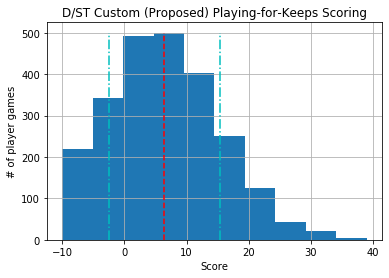

In [34]:
avg = df.ProposedCustFPts.mean()
std = df.ProposedCustFPts.std()
df.ProposedCustFPts.hist()
plt.title("D/ST Custom (Proposed) Playing-for-Keeps Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 500, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(df.where(df.ProposedCustFPts > 20).G.count(), df.where(df.ProposedCustFPts > 20).G.count() / df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(df.where(df.ProposedCustFPts >= (avg - std)).where(df.ProposedCustFPts <= (avg + std)).G.count() / df.G.count()))

This score change bumps the average down by a little more than half a point, but bumps the max score seen in the last 5 full seasons by 8 points (from 47 to 39). It also tightens the deviation by about 2 points. This makes it less volitile then a QB, and close to a WR in likelihood to have a 21+ fantasy point game (WR is 6.7%).

Overall, as a GM, you're less likely to have your or your opponents score dramatically changed due to the D/ST (but it _can_ still happen). At the same time, if you pick a good defense (or good defense matchup), you'll still have a good showing from the D/ST. For example, last Sunday the Patriots would have scored 47 (10 above standard) versus 55 (18 above standard).

You can go to the next section and see both the stats for the last 5 seasons for all D/STs in the NFL in both the current custom scoring system (`CustFPts`) and the Proposed (`ProposedCustFPts`).

## Thanks y'all

Feel free to give us feedback on this proposed change. We spent (probably too much) time on both evaluating the current scoring system and settling on the best and fairest candidate to propose as a replacement. We want you all to have all the same information as us, and are happy to discuss or provide you with all the data to play with as you will.

# stats-appendix

In [38]:
pd.options.display.max_rows = 500
print('"count" means the number of games in the table below... sorry')
df.groupby(by=["Team", "Season"])[["CustFPts", "ProposedCustFPts"]].describe()

"count" means the number of games in the table below... sorry


CustFPts                                          \
                               count       mean        std   min   25%   50%   
Team                 Season                                                    
Arizona Cardinals    2014       15.0  12.266667  12.014674 -13.0   8.5  14.0   
                     2015       15.0  14.000000  12.375090  -3.0   5.5  12.0   
                     2016       15.0   6.333333  12.151817  -9.0  -3.0   3.0   
                     2017       15.0   6.866667  13.527045  -6.0  -4.0   5.0   
                     2018       15.0   3.533333   9.635253 -12.0  -4.0   5.0   
Atlanta Falcons      2014       15.0   4.000000  11.414277 -14.0  -2.5   2.0   
                     2015       15.0   6.800000   8.985703 -12.0   2.5   9.0   
                     2016       15.0   4.733333   9.617444  -6.0  -4.0   3.0   
                     2017       15.0   7.666667   5.354126   2.0   3.0   8.0   
                     2018       15.0   3.200000  11.384200 -13.0  -4.0   2.0   
Baltimore Ravens     2014       15.0  10.800000  10.171388  -5.0   1.5  12.0   
                     2015       15.0   3.800000   9.275159 -14.0  -1.0   3.0   
                     2016       15.0   9.133333  10.091486  -7.0   2.0  10.0   
                     2017       15.0  15.866667  17.991532 -14.0   4.0  16.0   
                     2018       15.0  12.200000  14.688188 -14.0   1.0  12.0   
Buffalo Bills        2014       15.0  12.333333  11.380853 -12.0   5.0  13.0   
                     2015       15.0   5.933333  11.713647 -13.0  -1.5   4.0   
                     2016       15.0   7.200000  14.348718 -14.0  -5.5   6.0   
                     2017       15.0   8.000000  11.982130 -14.0  -0.5  14.0   
                     2018       15.0   5.533333  12.281616 -12.0  -1.5   5.0   
Carolina Panthers    2014       15.0   3.800000  13.497090 -14.0 -10.5   9.0   
                     2015       15.0  11.200000  13.289093 -12.0   3.5  10.0   
                     2016       15.0   6.000000  11.218607 -11.0  -3.0   9.0   
                     2017       15.0   9.533333  11.550304  -6.0  -1.0  10.0   
                     2018       15.0   4.200000   8.628855 -13.0   0.5   4.0   
Chicago Bears        2014       15.0   4.000000  13.580448 -13.0  -6.5   3.0   
                     2015       15.0   3.600000  10.005713 -13.0  -2.0   4.0   
                     2016       15.0   4.733333  11.828939 -14.0  -2.5   1.0   
                     2017       15.0   9.266667  12.538322 -12.0   2.5  10.0   
                     2018       15.0  14.800000  12.768264 -11.0  11.0  17.0   
Cincinnati Bengals   2014       15.0   7.866667  13.973785 -14.0   1.0   9.0   
                     2015       15.0  12.200000   9.726253  -3.0   4.5  13.0   
                     2016       15.0   6.933333   9.676678 -11.0   2.0   5.0   
                     2017       15.0   7.600000   8.131069  -7.0   1.5  11.0   
                     2018       15.0   1.000000  11.526367 -14.0  -8.5   2.0   
Cleveland Browns     2014       15.0   8.800000   9.420343  -4.0   2.0   8.0   
                     2015       15.0   1.533333  10.308572 -13.0  -5.0  -4.0   
                     2016       15.0  -1.600000   5.603570 -14.0  -5.0  -2.0   
                     2017       15.0   2.800000   7.321202  -8.0  -4.0   2.0   
                     2018       15.0   4.733333   9.300282 -11.0  -3.5  10.0   
Dallas Cowboys       2014       15.0   5.666667   8.837151  -6.0  -1.5   4.0   
                     2015       15.0   5.333333  10.567245 -13.0  -3.5   3.0   
                     2016       15.0   8.533333   6.728051  -6.0   5.0  10.0   
                     2017       15.0   5.733333  13.734558 -14.0  -8.5   7.0   
                     2018       15.0   9.133333   7.199868  -3.0   2.5  10.0   
Denver Broncos       2014       15.0   7.000000   9.724784 -11.0   4.0   9.0   
                     2015       15.0  13.533333  10.391388  -5.0   8.0  14.0   
                     2016   

avg: 6.2, standard deviation: 4.7
32 games at 21+ Fantasy Points (roughly 1.3% of games)
73% of games are within 1 standard deviation of the average fantasy score


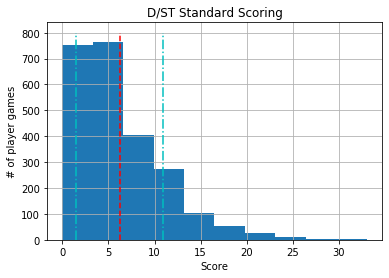

In [19]:
avg = df.FPts.mean()
std = df.FPts.std()
df.FPts.hist()
plt.title("D/ST Standard Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 800, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(df.where(df.FPts > 20).G.count(), df.where(df.FPts > 20).G.count() / df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(df.where(df.FPts >= (avg - std)).where(df.FPts <= (avg + std)).G.count() / df.G.count()))

avg: 7.0, standard deviation: 11.5
285 games at 21+ Fantasy Points (roughly 11.9% of games)
64% of games are within 1 standard deviation of the average fantasy score


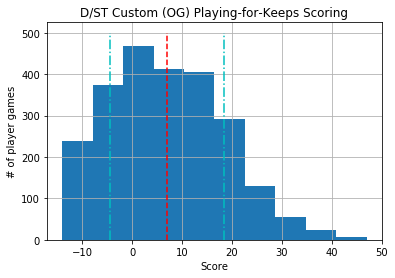

In [20]:
avg = df.CustFPts.mean()
std = df.CustFPts.std()
df.CustFPts.hist()
plt.title("D/ST Custom (OG) Playing-for-Keeps Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 500, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(df.where(df.CustFPts > 20).G.count(), df.where(df.CustFPts > 20).G.count() / df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(df.where(df.CustFPts >= (avg - std)).where(df.CustFPts <= (avg + std)).G.count() / df.G.count()))

avg: 6.4, standard deviation: 9.0
165 games at 21+ Fantasy Points (roughly 6.9% of games)
66% of games are within 1 standard deviation of the average fantasy score


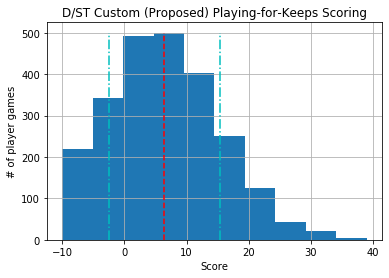

In [32]:
avg = df.ProposedCustFPts.mean()
std = df.ProposedCustFPts.std()
df.ProposedCustFPts.hist()
plt.title("D/ST Custom (Proposed) Playing-for-Keeps Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 500, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(df.where(df.ProposedCustFPts > 20).G.count(), df.where(df.ProposedCustFPts > 20).G.count() / df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(df.where(df.ProposedCustFPts >= (avg - std)).where(df.ProposedCustFPts <= (avg + std)).G.count() / df.G.count()))

avg: 10.8, standard deviation: 5.4
268 games at 21+ Fantasy Points (roughly 6.7% of games)
74% of games are within 1 standard deviation of the average fantasy score


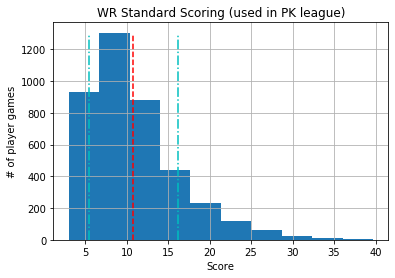

In [22]:
avg = wr_df.FPts.mean()
std = wr_df.FPts.std()
wr_df.FPts.hist()
plt.title("WR Standard Scoring (used in PK league)")
plt.vlines([avg, avg + std, avg - std], 0, 1300, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(wr_df.where(wr_df.FPts > 20).G.count(), wr_df.where(wr_df.FPts > 20).G.count() / wr_df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(wr_df.where(wr_df.FPts >= (avg - std)).where(wr_df.FPts <= (avg + std)).G.count() / wr_df.G.count()))

avg: 10.2, standard deviation: 6.7
385 games at 21+ Fantasy Points (roughly 9.6% of games)
77% of games are within 1 standard deviation of the average fantasy score


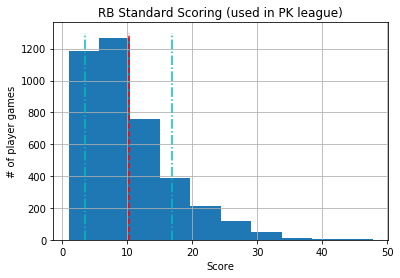

In [39]:
avg = rb_df.FPts.mean()
std = rb_df.FPts.std()
rb_df.FPts.hist()
plt.title("RB Standard Scoring (used in PK league)")
plt.vlines([avg, avg + std, avg - std], 0, 1300, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(rb_df.where(rb_df.FPts > 20).G.count(), rb_df.where(rb_df.FPts > 20).G.count() / rb_df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(rb_df.where(rb_df.FPts >= (avg - std)).where(rb_df.FPts <= (avg + std)).G.count() / rb_df.G.count()))

avg: 14.7, standard deviation: 10.0
791 games at 21+ Fantasy Points (roughly 28.5% of games)
65% of games are within 1 standard deviation of the average fantasy score


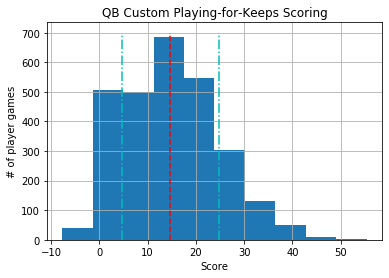

In [41]:
avg = qb_df.CustFPts.mean()
std = qb_df.CustFPts.std()
qb_df.CustFPts.hist()
plt.title("QB Custom Playing-for-Keeps Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 700, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(qb_df.where(qb_df.CustFPts > 20).G.count(), qb_df.where(qb_df.CustFPts > 20).G.count() / qb_df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(qb_df.where(qb_df.CustFPts >= (avg - std)).where(qb_df.CustFPts <= (avg + std)).G.count() / qb_df.G.count()))